In [107]:
%matplotlib inline
from __future__ import print_function

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2
 
from utils.nolearn_net import NeuralNet
from utils.data_utils import *
from utils.iterator import BaseBatchIterator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
import os
os.getcwd()

'/Users/thorey/Documents/project/competition/fognet'

In [109]:
from model_defs import lstm

# Load data 

In [110]:
data = load_raw_data()

# Preprocessing 

The training set consist of measurements every 2 hours on the station.
While the lag between most of measurements is 2h, some of them show a larger time difference.
We first use that to define some group in the training set.

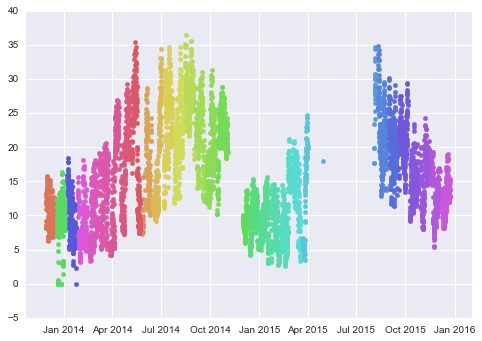

In [3]:
df_train =  add_group_column_to_data(data['micro_train'])
i= 0
for key,gp in df_train.groupby('group'):
    plt.scatter(gp.index,gp.temp,color = sns.color_palette('hls',len(df_train.groupby('group')))[i])
    i+=1

## Train/Val/Test split

We are going to split that thing in three different group train/val/test

- I take the 20 first group for training
- I take the 7 that follows for validation
- I take the 8 remaining for testing

In [11]:
train,val,test = train_val_test_split(data['micro_train'],data['labels'])

Le train is composed by 19 group and 3354 observation
Le val is composed by 7 group and 1083 observation
Le test is composed by 8 group and 1361 observation


## Processing to feed the data to a RNN 

In [12]:
from sklearn.preprocessing import Imputer
inputer = Imputer(strategy='mean')
inputer.fit(train[train.columns[:-2]])
def df_transform(inputer,df):
    df_tmp = pd.DataFrame(inputer.transform(df[df.columns[:-2]]),
                          columns = df.columns[:-2],
                          index = df.index)
    return df_tmp.join(df[df.columns[-2:]])

In [13]:
train_tmp = df_transform(inputer,train)
val_tmp = df_transform(inputer,val)
batch_iterator = BaseBatchIterator(feats=train.columns.tolist()[:-2],
                                   label='yield',
                                   batch_size=5,
                                   size_seq=24,
                                   stride=1)
batch_iterator_train = batch_iterator(train_tmp)
batch_iterator_val = batch_iterator(val_tmp)

# RNN MODEL 

In [14]:
import theano.tensor as TT 
import lasagne
## Parameters
# batch size : N
# Seq length : T
# Num features : D
# Size hidden layer

D = 9
H = 100
GRAD_CLIP = 10
# First, we build the network, starting with an input layer
# Recurrent layers expect input of shape
# (batch size, SEQ_LENGTH, num_features)

l_in = lasagne.layers.InputLayer(name='in', 
                                 shape=(None, None, D))
batchsize, seqlen, _ = l_in.input_var.shape

# We now build the LSTM layer which takes l_in as the input layer
# We clip the gradients at GRAD_CLIP to prevent the problem of exploding
# gradients.

l_lstm = lasagne.layers.LSTMLayer(l_in, 
                                     H,
                                     name='lstm',
                                     grad_clipping=GRAD_CLIP,
                                     nonlinearity=lasagne.nonlinearities.tanh)
l_shp = lasagne.layers.ReshapeLayer(l_lstm, (-1, H))
l_dense = lasagne.layers.DenseLayer(l_shp, 
                                    num_units=1,
                                   name = 'dense',
                                   nonlinearity = lasagne.nonlinearities.identity)
l_out = lasagne.layers.ReshapeLayer(l_dense, (batchsize, seqlen))

In [92]:
a = {'a':1,'b':2}

In [99]:
'_'.join([f+'_'+str(g) for f,g in a.iteritems()])

'a_1_b_2'

In [105]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--conf', required=True)
parser.add_argument('--reg', default=1e-7,type = float)

_StoreAction(option_strings=['--reg'], dest='reg', nargs=None, const=None, default=1e-07, type=<type 'float'>, choices=None, help=None, metavar=None)

In [21]:
from utils.nolearn_net import NeuralNet
net = NeuralNet(
    layers=l_out,
    regression=True,
    objective_loss_function=lasagne.objectives.squared_error,
    objective_l2=1e-7,
    update=lasagne.updates.adam,
    update_learning_rate=1e-4,
    train_split = False,
    batch_iterator_train=batch_iterator_train,
    batch_iterator_test=batch_iterator_val,
    verbose=15,
    max_epochs=10000,
)
net.initialize()

net.fit(epochs = 10)

# Neural Network with 44401 learnable parameters

## Layer information

  #  name    size
---  ------  --------
  0  in      Nonex9
     lstm    Nonex100
             100
     dense   1
             None

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       8.31525       7.80321      1.06562  3.97s
      2       8.11391       7.76712      1.04465  3.98s
      3       8.06742       7.71599      1.04555  4.06s
      4       8.00175       7.66330      1.04416  3.92s
      5       7.98521       7.64379      1.04467  3.96s
      6       7.92519       7.56629      1.04743  3.96s
      7       7.87286       7.50716      1.04871  4.04s
      8       7.83615       7.51236      1.04310  3.99s
      9       7.84308       7.44369      1.05365  3.94s
     10       7.73885       7.39076      1.04710  3.97s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<utils.iterator.BaseBatchIterator object at 0x103ba2850>,
     batch_iterator_train=<utils.iterator.BaseBatchIterator object at 0x103ba2850>,
     custom_scores=None,
     layers=[<lasagne.layers.shape.ReshapeLayer object at 0x122fd0110>],
     loss=None, max_epochs=10000, more_params={},
     objective=<function objective at 0x116c06cf8>, objective_l2=1e-07,
     objective_loss_function=<function squared_error at 0x116a1e1b8>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x1172a7908>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x1172a7ab8>],
     regression=True, train_split=False,
     update=<function adam at 0x116a23410>, update_learning_rate=0.0001,
     use_label_encoder=False, verbose=15,
     y_tensor_type=TensorType(float64, matrix))

In [80]:
import os

In [83]:
os.path.expanduser

<function posixpath.expanduser>

In [84]:
root = '/Users/thorey/Documents/project/competition/fognet/models/lstm/model_0'

In [86]:
import json

In [89]:
with open(os.path.join(root,'conf_model.json')) as f:
    conf = json.load(f)

In [34]:
data = Data()

In [41]:
from utils.data_utils import *

In [42]:
        inputer = MyImputer(strategy='mean')
        inputer.fit(train[train.columns[:-2]])

MyImputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [46]:
data.process_data_benchmark()

Le train is composed by 19 group and 3354 observation
Le val is composed by 7 group and 1083 observation
Le test is composed by 8 group and 1361 observation


(<utils.iterator.BaseBatchIterator at 0x12a78dcd0>,
 <utils.iterator.BaseBatchIterator at 0x12a78dcd0>)

In [57]:
import importlib

In [71]:
architecture = importlib.import_module('model_defs.lstm')
builder = getattr(architecture,'build_simple_lstm')
builder(D=2, H=100, GRAD_CLIP=10)

In [79]:
len(batch_iterator_train.feats)

9

In [74]:
for Xb,yb in batch_iterator_val:
    print(Xb.shape,Xb)
    sys.exit()

(5, 24, 9) [[[   0.            0.31970725   16.09583333 ...,    1.89463333  123.875
      1.75630833]
  [   0.            0.33959684   15.39166667 ...,    2.351525    127.66666667
      2.1126    ]
  [   0.            0.3518744    14.75       ...,    2.28026667  133.25
      2.03715   ]
  ..., 
  [   0.            0.21601246   16.625      ...,    3.458125     86.
      2.88386667]
  [   0.            0.22197128   16.025      ...,    3.99046667
     82.29166667    3.18566667]
  [   0.            0.24527263   15.36666667 ...,    3.6216       79.29166667
      3.09345   ]]

 [[   0.            0.33959684   15.39166667 ...,    2.351525    127.66666667
      2.1126    ]
  [   0.            0.3518744    14.75       ...,    2.28026667  133.25
      2.03715   ]
  [   0.            0.34813538   14.95833333 ...,    2.14613333
    141.04166667    1.92816667]
  ..., 
  [   0.            0.22197128   16.025      ...,    3.99046667
     82.29166667    3.18566667]
  [   0.            0.24527263   15.

SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


In [56]:
    getattr(lasagne.objectives,'squared_error')

<function lasagne.objectives.squared_error>

In [53]:
getattr(data,'process_data_benchmark')()

Le train is composed by 19 group and 3354 observation
Le val is composed by 7 group and 1083 observation
Le test is composed by 8 group and 1361 observation


(<utils.iterator.BaseBatchIterator at 0x12a78d0d0>,
 <utils.iterator.BaseBatchIterator at 0x12a78d0d0>)

In [10]:
net.batch_iterator_train = batch_iterator_train
net.batch_iterator_test = batch_iterator_val
net.initialize()

In [26]:
net.get_score_whole_set('test')

1.3686325759270976

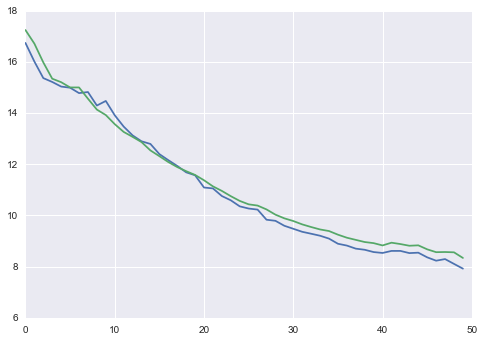

In [16]:
plt.plot([f['valid_loss'] for f in net.train_history_])
plt.plot([f['train_loss'] for f in net.train_history_])

In [2]:
import numpy as np
np.sqrt(3.8)

1.9493588689617927

In [20]:
net.predict()

array([[ 0.91455285,  0.05339446, -0.03429878, ..., -0.08039147,
        -0.07265196, -0.03766962],
       [ 1.13275435,  0.13893034, -0.03259964, ..., -0.07209404,
        -0.03736325,  0.08674202],
       [ 1.31006544,  0.15349411, -0.00247873, ..., -0.03683145,
         0.0877185 ,  0.16245854],
       ..., 
       [ 0.02781247, -0.34743854, -0.27740044, ...,  0.13347038,
        -0.22354135,  0.23109068],
       [ 0.5709322 , -0.23337237, -0.06095584, ..., -0.22228495,
         0.2327262 ,  0.04284291],
       [ 0.78388102, -0.03150363, -0.03977821, ...,  0.234507  ,
         0.04353782, -0.18843932]])

In [ ]:
for Xb,yb in 